In [136]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.color import rgb2gray
from scipy.optimize import leastsq

原图片高度：1440,原图片宽度：2560


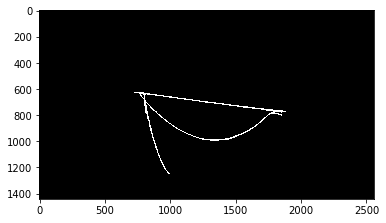

In [137]:
#读取原图片
file = ".\\figure\\14.png"
Image = plt.imread(file);
if len(Image.shape) == 3:
    Image = rgb2gray(Image)
[image_y_max,image_x_max] = Image.shape;
print(f"原图片高度：{image_y_max},原图片宽度：{image_x_max}");
plt.imshow(Image,cmap = "gray");
plt.show()

min_x:727,max_x:1884,min_y:622,max_y:1251

裁剪后长度:629，裁剪后宽度:1157



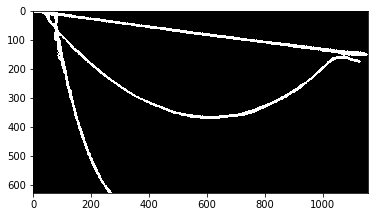

In [138]:
#裁剪原图片
min_x = max_x = min_y = max_y = 0;
sum_col = np.sum(Image,axis=0);
for i in range(0,image_x_max):
    if (sum_col[i] != 0):
        min_x = i;
        break;
for i in range(image_x_max-1,min_x,-1):
    if (sum_col[i] != 0):
        max_x = i;
        break;


sum_row = np.sum(Image,axis=1);
for i in range(0,image_y_max):   
    if (sum_row[i] != 0):
        min_y = i;
        break; 
for i in range(image_y_max - 1,min_y,-1):
    if (sum_row[i] != 0):
        max_y = i;
        break;

Image = Image[min_y:max_y,min_x:max_x];

print('min_x:%d,max_x:%d,min_y:%d,max_y:%d\n'%(min_x,max_x,min_y,max_y));
[image_y_max, image_x_max] =  Image.shape;
print('裁剪后长度:%d，裁剪后宽度:%d\n' %(image_y_max,image_x_max));
plt.imshow(Image,cmap = "gray");
plt.show();

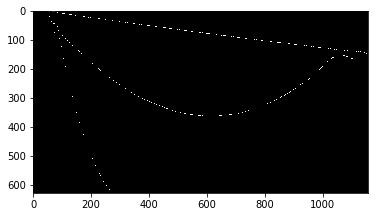

In [139]:
#上侧边缘提取

for x in range(0,image_x_max): 
    is_white = False;
    for y in range(image_y_max-1,-1,-1):
        v = x;
        u = -y + image_y_max - 1;
        if (Image[u,v] == 1):
            if (is_white == False):
                is_white = True;
            else:
                Image[u,v] = 0;
        else:
            is_white = False;

plt.imshow(Image,cmap = "gray");
plt.show();

In [ ]:
#判断有几条曲线，选择能够提供充分样点的最大曲线数。
count = np.sum(Image,axis = 0);
num_curve = int(np.max(count));
num_curve_part = np.where(count==num_curve);
length = len(num_curve_part);
print(length);
min_length = round(image_x_max/20);
print(min_length);
while (length < min_length):
    count[num_curve_part] = 0;
    num_curve = np.max(count);
    num_curve_cut = np.where(count==num_curve);
    length = len(num_curve_cut);
    
print("判定缆绳数量为：%d" %(num_curve));
        


1
58


截取起点：84, 截取长度：1



D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.


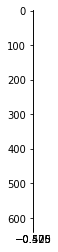

In [141]:
##根据像素矩阵的列和判断是否有交点，我们希望截取一段无交点部分(最长的部分)
length = 0;
start = end = 0;
share_index = 0;
while (start < image_x_max) and (end < image_x_max):
    while (start < image_x_max ) and (count[start] != num_curve):
        start = start + 1;
    end = start + 1;
    while (end < image_x_max) and (count[end] == num_curve):
        end = end + 1;
    sublength = end - start;
    if (sublength > length):
        length = sublength;
        share_index = start;
    start = end + 1;
print('截取起点：%d, 截取长度：%d\n' %(share_index,length));
Image_cut  = Image[ : ,share_index : share_index + length - 1];
[imagecut_y_max,imagecut_x_max] = Image_cut.shape;
plt.imshow(Image_cut,cmap = "gray");
plt.show()

In [142]:
#截取初始用来回归的点
sample_points = np.zeros((imagecut_x_max,2,num_curve));
for i in range(0,imagecut_x_max):
    curve_id = 0;
    for j in range(imagecut_y_max-1,-1,-1):
        x = i + share_index;
        y = -j + imagecut_y_max - 1;
        if (Image_cut[y,i] == 1):
            sample_points[i,0,curve_id] = x;
            sample_points[i,1,curve_id] = j;
            curve_id  = curve_id + 1;
print(sample_points) 

[]


In [131]:
def function(x, a, b, c):
    result = a * np.cosh((x-b)/a) + c
    return result

In [132]:
def f_err(p, y, x):
    return y - function(x, *p)

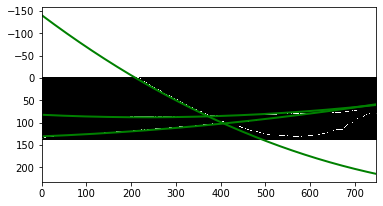

y = 1562.739491*cosh((x- 1083.847790)/1562.739491) + -1673.635917 

y = 4829.980250*cosh((x- 232.713394)/4829.980250) + -4778.036003 

y = 6812.148198*cosh((x- -278.328049)/6812.148198) + -6808.585996 



In [133]:
#开始第一次拟合
parameter_origin = np.zeros((num_curve,3));
for i in range(0,num_curve):
    y = sample_points[:,1,i];
    x = sample_points[:,0,i];
    parameter_initial = [imagecut_y_max,imagecut_x_max,-imagecut_y_max];
    [parameter, _] = leastsq(f_err, parameter_initial, args=(y, x));
    parameter_origin[i,:] = parameter;
                                     

plt.imshow(Image,cmap = "gray");
for id  in range(0,num_curve):
    t = parameter_origin[id,:];
    x_fit = np.zeros((image_x_max,1));
    y_fit = np.zeros((image_x_max,1));
    
    for x in range(0,image_x_max):
        x_fit[x] = x;
        y_fit[x] = t[0]*np.cosh((x - t[1])/ t[0]) + t[2];
        
    u_fit = - y_fit + image_y_max;
    plt.plot(x_fit,u_fit,color = 'green',linewidth = 2);
plt.show()

for id in range(0,num_curve):
    a = parameter_origin[id,0];
    b = parameter_origin[id,1];
    c = parameter_origin[id,2];
    print("y = %f*cosh((x- %f)/%f) + %f \n" %(a,b,a,c));

In [134]:
def CalculateParameter(Image,sample_points_origin,parameter_origin,iterate_time):
    [image_y_max,image_x_max] = Image.shape;
    num_curve = int(parameter_origin.shape[0]);
    parameter_old = parameter_origin;
    sample_points_old = sample_points_origin;
    
    expansion_size = int(round(image_x_max/iterate_time));
    
    for time in range(0,iterate_time):        

        pnt_num = sample_points_old.shape[0];
        x_cut_min = sample_points_old[0,0,0];
        x_cut_max = sample_points_old[pnt_num-1,0,0];
        if (x_cut_min > expansion_size):
            x_cut_min = x_cut_min - expansion_size;
        else:
            x_cut_min = 0;
        
        if ( image_x_max - x_cut_max >= expansion_size):
            x_cut_max = x_cut_max + expansion_size;
        else:
            x_cut_max = image_x_max - 1;
        
        x_cut_size = int(x_cut_max - x_cut_min + 1);
        sample_points_new = np.zeros((x_cut_size,2,num_curve));
        for id in range(0,num_curve):
            for x in range(0,x_cut_size):
                sample_points_new[x,0,id] = x + x_cut_min; 

        for  x  in range(0,x_cut_size):
            for y in range(image_y_max-1,-1,-1):
                u = int(-y + image_y_max - 1);
                v = int(x + x_cut_min);
                if (Image[u,v] == 1):
                    y_distance = np.zeros((num_curve,1));
                    for id in range(0,num_curve):
                        t = parameter_old[id,:];
                        y_fit = t[0]*np.cosh((v - t[1])/ t[0]) + t[2];
                        y_distance[id] = np.abs(y_fit - y);
                    
                    #寻找离这个点最近的曲线
                    min_distance = np.min(y_distance);
                    if (min_distance < 12):
                        curve_id = np.where(y_distance == min_distance);
                        sample_points_new[x,1,curve_id] = y;


        parameter_new = np.zeros((num_curve,3));
        for id in range(0, num_curve):
            sample_x = sample_points_new[:,0,id];
            sample_y = sample_points_new[:,1,id];
            #将曲线中没有选定点的列删除。
            zero_column = np.where(sample_y == 0);
            sample_x = np.delete(sample_x,zero_column);
            sample_y = np.delete(sample_y,zero_column);

            
            parameter_initial = [image_y_max,image_x_max,-image_y_max]; 
            [parameter, _] = leastsq(f_err, parameter_initial, args=(sample_y, sample_x));      
            parameter_new[id,:] = parameter;             

        for id in range(0,num_curve):
            a = parameter_new[id,0];
            b = parameter_new[id,1];
            c = parameter_new[id,2];
            print("y = %f*cosh((x- %f)/%f) + %f \n" %(a,b,a,c))   
        parameter_old = parameter_new;
        sample_points_old = sample_points_new;
    return [parameter_old,sample_points_old];

In [135]:
[parameter,sample_points] = CalculateParameter(Image,sample_points,parameter_origin,2);
for id in range(0,num_curve):
    a = parameter[id,0];
    b = parameter[id,1];
    c = parameter[id,2];
    print("y = %f*cosh((x- %f)/%f) + %f \n" %(a,b,a,c));

y = 13788.479287*cosh((x- -839.454227)/13788.479287) + -13808.028931 

y = 12322.316766*cosh((x- 141.854499)/12322.316766) + -12271.148749 

y = 22192.224325*cosh((x- -1617.623166)/22192.224325) + -22246.405863 

y = 8876810.288147*cosh((x- -772368.714060)/8876810.288147) + -8910429.444535 

y = 38767.456136*cosh((x- -250.256192)/38767.456136) + -38718.362331 

y = 21244.476285*cosh((x- -1556.767568)/21244.476285) + -21296.861853 

y = 8876810.288147*cosh((x- -772368.714060)/8876810.288147) + -8910429.444535 

y = 38767.456136*cosh((x- -250.256192)/38767.456136) + -38718.362331 

y = 21244.476285*cosh((x- -1556.767568)/21244.476285) + -21296.861853 



In [120]:
radian = np.zeros((num_curve,1));
for id in range(0,num_curve):
    sample_x = sample_points[:,0,id];
    sample_y = sample_points[:,1,id];
    #将曲线中没有选定点的列删除。
    zero_column = np.where(sample_y == 0);
    sample_x = np.delete(sample_x,zero_column);
    sample_y = np.delete(sample_y,zero_column);
            
    #取出样本点的起点和终点，画出直线。
    pnt_num = sample_x.shape[0];
    x_start = sample_x[0];
    y_start = sample_y[0];
    x_end = sample_x[pnt_num-1];
    y_end = sample_y[pnt_num-1];
            
    #起点到终点的直线。
    k = (y_end - y_start) / (x_end - x_start);
    b = y_end - k * x_end;
            

            
    #计算曲线到直线的距离，取出最大值计算弯曲度
    line_length  = np.sqrt(pow(x_end - x_start,2) + pow(y_end - y_start,2));
    distance = np.zeros((pnt_num,1));
    for i in range(0,pnt_num):
        distance[i] = np.abs(k*sample_x[i] - sample_y[i] + b) / np.sqrt(1 + k*k);

    max_distance = np.max(distance);
    radian[id] = max_distance / line_length;
    print("y = %f x + %f \n" %(k,b));
print(radian)

y = 0.073529 x + 2.000000 

y = 0.010355 x + 49.254438 

y = 0.091195 x + 2.000000 

[[0.03111128]
 [0.01641923]
 [0.00705144]]


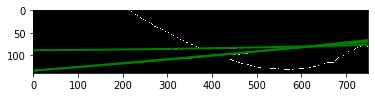

In [121]:
plt.imshow(Image,cmap = "gray");
for id  in  range(0,num_curve):
    t = parameter[id,:];
    x_fit = np.zeros((image_x_max,1));
    y_fit = np.zeros((image_x_max,1));
    for x in range(0,image_x_max):
        x_fit[x] = x;
        y_fit[x] = t[0]*np.cosh((x - t[1])/ t[0]) + t[2];
    u_fit = - y_fit + image_y_max - 1;
    plt.plot(x_fit,u_fit,color = 'green',linewidth = 2);
plt.show()

In [ ]:
def test_lsq:
    for f in range(1,16):
    {  
        file_path = ".\\figure\\";
        file_name =  str(f);
        file_ext = ".png";
        file = file_name + file_path + file_ext;
        lsq(file);
    }